In [1125]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import norm
from sklearn.metrics import r2_score

In [1126]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data_juli.csv", sep=",")

In [1127]:
df.dropna(inplace=True)

In [1128]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [1129]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [1130]:
candidate_lags = range(1, 18) 
#candidate_lags= [2,3,4]

In [1131]:
cutoffs = pd.date_range(
    start="2020-09-30",   # first end-of-month
    end="2021-08-31",     # last end-of-month
    freq="ME"              # month-end
).to_list()

In [1132]:
cutoffs

[Timestamp('2020-09-30 00:00:00'),
 Timestamp('2020-10-31 00:00:00'),
 Timestamp('2020-11-30 00:00:00'),
 Timestamp('2020-12-31 00:00:00'),
 Timestamp('2021-01-31 00:00:00'),
 Timestamp('2021-02-28 00:00:00'),
 Timestamp('2021-03-31 00:00:00'),
 Timestamp('2021-04-30 00:00:00'),
 Timestamp('2021-05-31 00:00:00'),
 Timestamp('2021-06-30 00:00:00'),
 Timestamp('2021-07-31 00:00:00'),
 Timestamp('2021-08-31 00:00:00')]

In [1133]:
###resultat valg 2021
valg = {
    "Ap": [26.3],
    "Høyre": [20.4],
    "Frp": [11.6],
    "SV": [7.6],
    "Sp": [13.5],
    "KrF": [3.8],
    "Venstre": [4.6],
    "MDG": [3.9],
    "Rødt": [4.7],
    "Andre": [3.6],
}

###resultat valg 2017
#valg = {
#    "Ap": [27.4],
#    "Høyre": [25.0],
#    "Frp": [15.2],
#    "SV": [6.0],
#    "Sp": [10.3],
#    "KrF": [4.2],
#    "Venstre": [4.4],
#    "MDG": [3.2],
#    "Rødt": [2.4],
#    "Andre": [1.8],
#}



# Lage DataFrame
valg_df = pd.DataFrame(valg)
results = []
finals = []

In [1134]:
y_true = valg_df.values.reshape(1, -1)[0]

In [1135]:
for i, cutoff in enumerate(cutoffs):
    for lag in candidate_lags:
            # Fit model on training set
            df_en=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]

            df_ex=df[[
            'Ap_skandale_lag6', 
            'Hoyre_skandale_lag6', 
            'Frp_skandale_lag6',
            'Ap_reg_lag6',
            'Hoyre_reg_lag6',   
            'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
            'styringsrente_trend3', 'styringsrente_trend6']].iloc[1:]


            steps = len(cutoffs) - i +1

            ex_future=df_ex.loc[df_ex.index >= cutoff][:steps]
        
            df_en=df_en.loc[df_en.index <= cutoff]
            df_ex=df_ex.loc[df_ex.index <= cutoff]
            
            df_orig=df_en
            df_en_val = df_en.diff().dropna() 
            

            #print(ex_future)
            #print(cutoff)
            #model = VAR(df_en_val)
            model = VAR(endog=df_en_val, exog=df_ex)
            
            model_fitted = model.fit(maxlags=lag, trend='c', method = 'ols')
            #print(model_fitted.summary())
            
            #print(f"lag={lag}, steps={steps} and cutoff={cutoff}")
            forecast_dates = pd.date_range(start=cutoff, periods=steps, freq='ME')
            #print(forecast_dates)
            forecast = model_fitted.forecast(df_en_val.values[-model_fitted.k_ar:], steps=steps,  exog_future=ex_future)
            #print(forecast)
            
            last_actual_value = df_orig.iloc[-1]  # Last known actual data point
            #print(last_actual_value)
            forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en_val.columns)
    
            forecast_df = forecast_df.cumsum() + last_actual_value
            date_to_extract = "2021-09-30"
            estimate_row = forecast_df.loc[date_to_extract]
            finals.append(estimate_row)
            #print(estimate_row.values)

            y_pred = estimate_row.values.reshape(1, -1)[0]  
            # Compute error metric (MSE here)
            mse = median_absolute_error(y_true, y_pred)
            mse_pp = median_absolute_error(y_true, last_actual_value.values.reshape(1, -1)[0])
    
            results.append((cutoff,lag,steps, mse, mse_pp))


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31

In [1136]:
last_actual_value.values.reshape(1, -1)[0]

array([24. , 20.1, 10.3,  8.8, 14.1,  3.6,  4.1,  5.5,  5.2,  4.4])

In [1137]:
y_true

array([26.3, 20.4, 11.6,  7.6, 13.5,  3.8,  4.6,  3.9,  4.7,  3.6])

In [1138]:
finals

[Ap         15.920854
 Hoyre      26.000852
 Frp        19.465222
 SV          8.608079
 SP         14.333230
 KrF         3.259589
 Venstre     3.018456
 MDG         3.536679
 Rodt        4.205557
 Andre       1.696974
 Name: 2021-09-30 00:00:00, dtype: float64,
 Ap         15.122265
 Hoyre      24.985262
 Frp        20.164718
 SV          8.618119
 SP         14.383710
 KrF         2.991531
 Venstre     3.199062
 MDG         4.137619
 Rodt        4.541605
 Andre       1.841533
 Name: 2021-09-30 00:00:00, dtype: float64,
 Ap         14.647126
 Hoyre      25.088650
 Frp        20.330503
 SV          8.534446
 SP         13.982228
 KrF         3.014519
 Venstre     3.427018
 MDG         4.418552
 Rodt        4.673934
 Andre       1.901745
 Name: 2021-09-30 00:00:00, dtype: float64,
 Ap         15.849903
 Hoyre      25.775500
 Frp        18.117252
 SV          8.577095
 SP         14.720227
 KrF         2.647628
 Venstre     2.966167
 MDG         4.590448
 Rodt        4.813171
 Andre    

In [1139]:
results_df=pd.DataFrame(results, columns=["cutoff", "lag", "steps", "MSE", "mse_pp"])

In [1140]:
results_df

,cutoff,lag,steps,MSE,mse_pp
0,2020-09-30,1,13,1.294812,0.9
1,2020-09-30,2,13,1.209529,0.9
2,2020-09-30,3,13,1.053714,0.9
3,2020-09-30,4,13,1.354395,0.9
4,2020-09-30,5,13,1.442570,0.9
...,...,...,...,...,...
199,2021-08-31,13,2,5.842374,0.7
200,2021-08-31,14,2,3.964778,0.7
201,2021-08-31,15,2,2.369273,0.7
202,2021-08-31,16,2,0.950677,0.7


In [1141]:
best_lags = results_df.loc[results_df.groupby("cutoff")["MSE"].idxmin()]

In [1142]:
best_lags

,cutoff,lag,steps,MSE,mse_pp
2,2020-09-30,3,13,1.053714,0.90
19,2020-10-31,3,12,0.885273,1.10
36,2020-11-30,3,11,0.916580,0.90
53,2020-12-31,3,10,1.035448,0.95
68,2021-01-31,1,9,0.601567,0.85
85,2021-02-28,1,8,0.854712,1.05
102,2021-03-31,1,7,0.810775,1.10
122,2021-04-30,4,6,0.899693,1.30
137,2021-05-31,2,5,1.043768,0.95
160,2021-06-30,8,4,0.499493,0.90


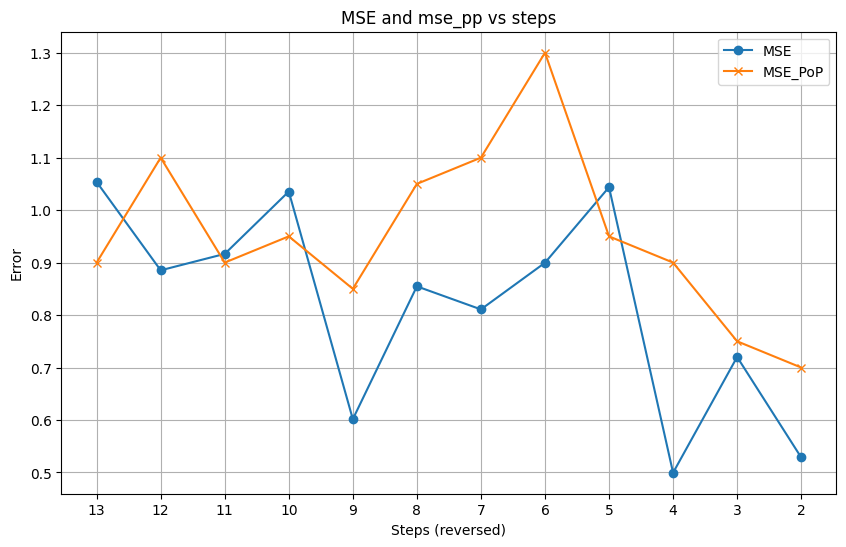

In [1143]:
df_sorted = best_lags.sort_values("steps", ascending=True)  # reverse lag order for x-axis

plt.figure(figsize=(10, 6))
plt.plot(df_sorted["steps"], df_sorted["MSE"], marker='o', label="MSE")
plt.plot(df_sorted["steps"], df_sorted["mse_pp"], marker='x', label="MSE_PoP")

plt.xlabel("Steps (reversed)")
plt.ylabel("Error")
plt.title("MSE and mse_pp vs steps")
plt.xticks(df_sorted["steps"])  # show all lag values on x-axis
plt.gca().invert_xaxis()      # reverse x-axis so largest lag is left
plt.legend()
plt.grid(True)
plt.show()

In [1144]:
filtered = results_df[results_df["lag"] == results_df["steps"]]
filtered = results_df[results_df["lag"] == 1]

In [1145]:
filtered

,cutoff,lag,steps,MSE,mse_pp
0,2020-09-30,1,13,1.294812,0.90
17,2020-10-31,1,12,1.314581,1.10
34,2020-11-30,1,11,1.393581,0.90
51,2020-12-31,1,10,1.713091,0.95
68,2021-01-31,1,9,0.601567,0.85
85,2021-02-28,1,8,0.854712,1.05
102,2021-03-31,1,7,0.810775,1.10
119,2021-04-30,1,6,0.961159,1.30
136,2021-05-31,1,5,1.189865,0.95
153,2021-06-30,1,4,0.997984,0.90


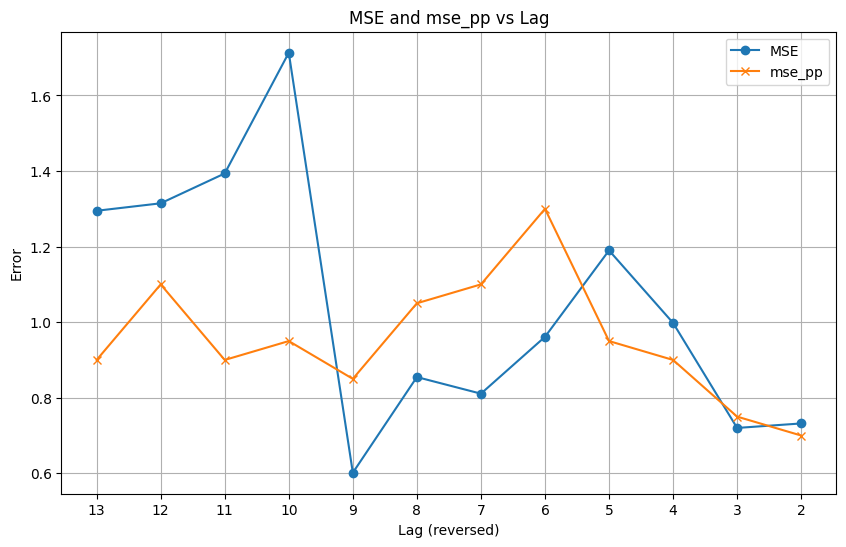

In [1146]:
df_sorted = filtered.sort_values("steps", ascending=False)  # reverse lag order for x-axis

plt.figure(figsize=(10, 6))
plt.plot(df_sorted["steps"], df_sorted["MSE"], marker='o', label="MSE")
plt.plot(df_sorted["steps"], df_sorted["mse_pp"], marker='x', label="mse_pp")

plt.xlabel("Lag (reversed)")
plt.ylabel("Error")
plt.title("MSE and mse_pp vs Lag")
plt.xticks(df_sorted["steps"])  # show all lag values on x-axis
plt.gca().invert_xaxis()      # reverse x-axis so largest lag is left
plt.legend()
plt.grid(True)
plt.show()